In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import IterativeImputer


# a) Dataset introduct

In [ ]:
lits_data = pd.read_stata('LiTSIII.dta' , convert_categoricals=False)

In [3]:
lits_data.to_csv('LiTSIII.csv')

In [12]:
lits_data['age_pr']

0        47
1        58
2        40
3        58
4        28
         ..
51201    44
51202    46
51203    67
51204    69
51205    60
Name: age_pr, Length: 51206, dtype: int8

In [13]:
lits_data.head()

,country,ID,interviewerID,PSU_number,PSU_name,district_l1,district_l2,region_name,urban,latitude,...,DURATION5,DURATION_ALL,InterviewerID,duration,q906a,q907a,q909a,q910a,q911a,q914a
0,Albania,10100002.0,zgI3YPEt,1,Shkolla 9 Vjecare,Shkoder,NaN,Shkoder,2,42.102861,...,NaN,NaN,,NaN,,,,,,
1,Albania,10100003.0,zgI3YPEt,1,Shkolla 9 Vjecare,Shkoder,NaN,Shkoder,2,42.102861,...,NaN,NaN,,NaN,Albania,,,,,
2,Albania,10100004.0,zgI3YPEt,1,Shkolla 9 Vjecare,Shkoder,NaN,Shkoder,2,42.102861,...,NaN,NaN,,NaN,Albania,Albania,Albania,Albania,Albania,
3,Albania,10100005.0,zgI3YPEt,1,Shkolla 9 Vjecare,Shkoder,NaN,Shkoder,2,42.102861,...,NaN,NaN,,NaN,Albania,,Albania,Albania,,
4,Albania,10100006.0,zgI3YPEt,1,Shkolla 9 Vjecare,Shkoder,NaN,Shkoder,2,42.102861,...,NaN,NaN,,NaN,Albania,Albania,Albania,Albania,Albania,


Get the number of rows and columns

In [14]:
num_rows = len(lits_data)
num_cols = len(lits_data.columns)

Print the number of rows and columns

In [15]:
print(num_rows)
print(num_cols)

51206
1290


 Print the column names

Print the frequency distribution of the 'country' column

In [35]:
print(lits_data['country'].value_counts())

country
Russia         1164
Kazakhstan     1084
Uzbekistan      905
Kyrgyz Rep.     761
Tajikistan      760
Name: count, dtype: int64


Filter the dataframe based on the countries

In [40]:
countries_to_include = ["Kazakhstan", "Kyrgyz Rep.", "Russia", "Tajikistan", "Uzbekistan"]
lits_data = lits_data[lits_data['country'].isin(countries_to_include)]

In [37]:
print(lits_data['country'].value_counts())

country
Russia         1164
Kazakhstan     1084
Uzbekistan      905
Kyrgyz Rep.     761
Tajikistan      760
Name: count, dtype: int64


filter the dataframe lits_data to only include rows that meet all the specified conditions.

In [39]:
# Renaming columns based on pattern matching
columns_to_rename = {
    next((col for col in lits_data.columns if "q901" in col), None): "Health",
    next((col for col in lits_data.columns if "q902" in col), None): "Weight",
    next((col for col in lits_data.columns if "q903" in col), None): "Height",
    next((col for col in lits_data.columns if "PRq501" in col), None): "WorkStatus",
    next((col for col in lits_data.columns if "PRq506" in col), None): "WorkHours",
    next((col for col in lits_data.columns if "q919b" in col), None): "SportsMember",
    next((col for col in lits_data.columns if "PRq511" in col), None): "Occupation",
    next((col for col in lits_data.columns if "q107_1" in col), None): "Divorce"
}
lits_data.rename(columns=columns_to_rename, inplace=True)



In [45]:
lits_data = lits_data[(lits_data['Weight'] > 0)&
                      (lits_data['Height'] > 0) & 
                      (lits_data['WorkStatus'] == 1) & 
                      (lits_data['Health'] > 0)
]


In [47]:
lits_data['gender_pr'].value_counts()

gender_pr
2    2401
1    2104
Name: count, dtype: int64

In [48]:
lits_data['Female'] = lits_data['gender_pr'].apply(lambda x: 1 if x == 2 else 0)

In [49]:
# Subset the data based on specific columns (I noticed "BMI" and "PreObese" were not defined in renaming, so I kept them as is)
my_data = lits_data[["Health", "Weight","Female", "Height", "WorkStatus",  "WorkHours", "SportsMember", "Divorce","age_pr"]]


# Missing observations

In [50]:
na_counts = my_data.isnull().sum()

print(na_counts)

Health             0
Weight             0
Female             0
Height             0
WorkStatus         0
WorkHours       1318
SportsMember       0
Divorce            0
age_pr             0
dtype: int64


In [ ]:
pip install fancyimpute

In [71]:
from fancyimpute import IterativeImputer

# Assuming my_data is already loaded as a DataFrame
# Use MICE for imputation
mice_imputer = IterativeImputer()
my_data_imputed = mice_imputer.fit_transform(my_data)

# Convert the imputed data back to a DataFrame (since fancyimpute returns a numpy array)
my_data = pd.DataFrame(data=my_data_imputed, columns=my_data.columns)

## Data visualization

# Train and test data frames.

In [51]:
import numpy as np

In [52]:
train_data.shape , test_data.shape

((3739, 10), (935, 10))

The variable for regression models


In [53]:
my_data['Weight']

24090    100.0
24091     65.0
24092     90.0
24093     78.0
24094     75.0
         ...  
51191     65.0
51194     90.0
51196     98.0
51200     88.0
51201     85.0
Name: Weight, Length: 4505, dtype: float64

In [54]:
import pandas as pd
# Assuming you already have a DataFrame named 'lits_data' and 'train_data' indices from before
my_data['BMI'] = my_data['Weight'] /((my_data['Height'] / 100) ** 2)


C:\Users\ilhom\AppData\Local\Temp\ipykernel_11284\505182350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['BMI'] = my_data['Weight'] /((my_data['Height'] / 100) ** 2)


In [56]:
# Display summary statistics of BMI for the training set
print(my_data['BMI'].describe())

count    4505.000000
mean       25.588224
std         4.438046
min        12.415943
25%        22.598140
50%        24.977043
75%        27.852008
max        53.877551
Name: BMI, dtype: float64


In [57]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


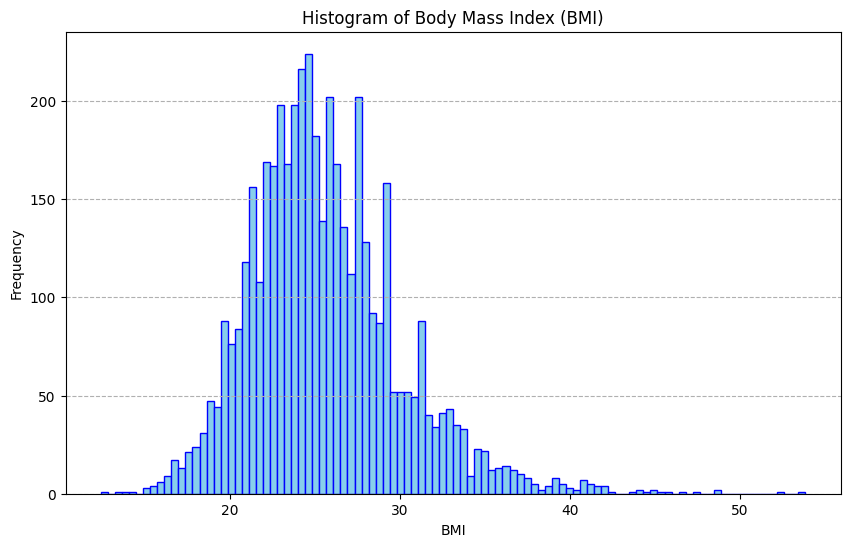

In [58]:
import matplotlib.pyplot as plt

# Assuming you already have a DataFrame named 'my_data' and 'train_data' indices from before

# Constructing the histogram
plt.figure(figsize=(10,6))
plt.hist(my_data['BMI'], bins=100, color='skyblue', edgecolor='blue')
plt.title('Histogram of Body Mass Index (BMI)')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--')

# Saving the histogram to a JPEG file
plt.savefig('BMI-hist.jpg')
plt.show()  # To display the histogram if needed


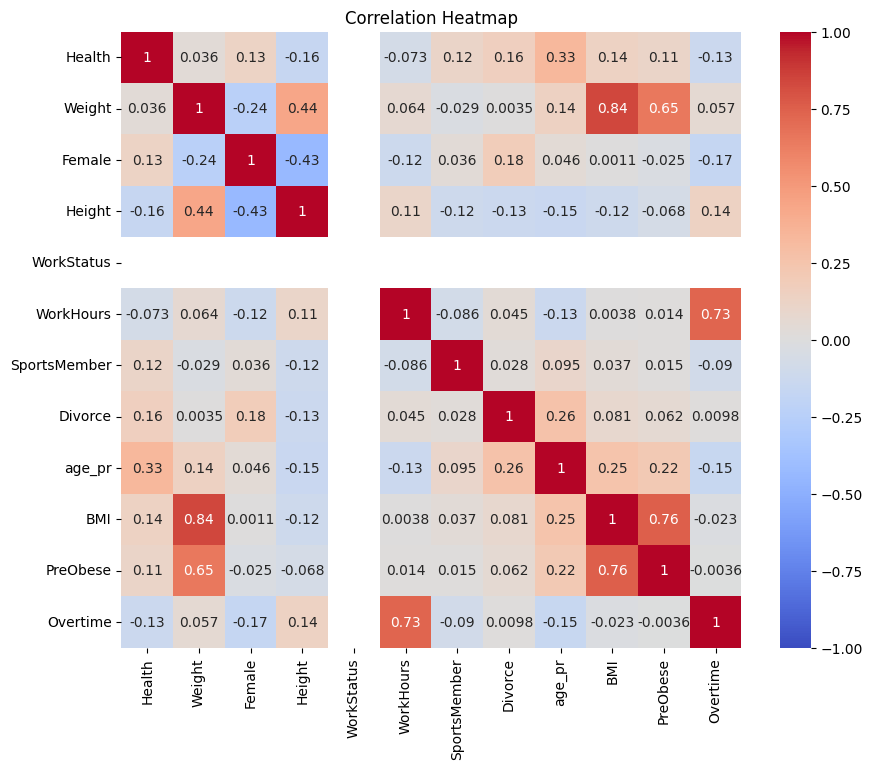

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = my_data.corr()
# Plot correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# Categorical response variable

In [59]:
my_data['PreObese'] = [1 if bmi >= 25 else 0 for bmi in my_data['BMI']]

C:\Users\ilhom\AppData\Local\Temp\ipykernel_11284\1807303267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['PreObese'] = [1 if bmi >= 25 else 0 for bmi in my_data['BMI']]


In [60]:
frequency_table = my_data['PreObese'].value_counts()
print(frequency_table)

PreObese
0    2280
1    2225
Name: count, dtype: int64


Regression and correlation

In [62]:
my_data['Overtime'] = [1 if x > 40 else 0 for x in lits_data['WorkHours']]


C:\Users\ilhom\AppData\Local\Temp\ipykernel_11284\2545635005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['Overtime'] = [1 if x > 40 else 0 for x in lits_data['WorkHours']]


In [ ]:
pip install seaborn

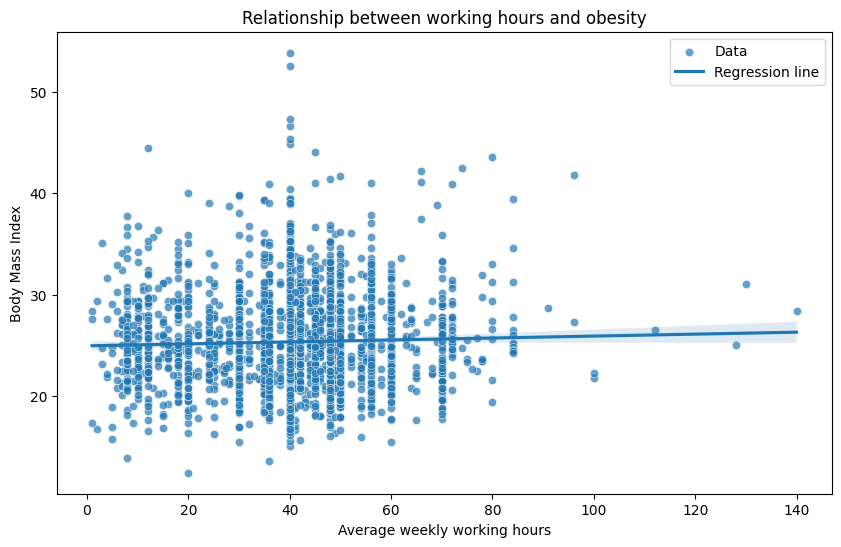

In [67]:
import seaborn as sns

# Assuming you already have a DataFrame named 'my_data' and 'train_data' indices from before

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=my_data, x=my_data['WorkHours'], y=my_data['BMI'], label="Data", alpha=0.7)

# Fit and plot the regression line
sns.regplot(data=my_data, x='WorkHours', y='BMI', scatter=False, label="Regression line")

# Set plot labels and title
plt.xlabel('Average weekly working hours')
plt.ylabel('Body Mass Index')
plt.title('Relationship between working hours and obesity')
plt.legend()

# Save the scatter plot to a JPEG file
plt.savefig('BMI-WorkHours-plot.jpg')
plt.show()  # To display the plot if needed


# **MODELS**

In [64]:
train_indices = np.random.choice(my_data.index, int(0.8 * len(my_data)), replace=False)
train_data = my_data.loc[train_indices]
test_data = my_data.drop(train_indices)

# -1 Linear regression models

In [ ]:
train_data

,Health,Weight,Female,Height,WorkStatus,WorkHours,SportsMember,Divorce,age_pr,BMI
27305,1.0,55.0,1,172.0,1.0,48.0,2.0,4,24,18.591130
49815,2.0,70.0,0,170.0,1.0,48.0,3.0,2,32,24.221453
27817,3.0,73.0,0,180.0,1.0,NaN,2.0,4,50,22.530864
46636,2.0,65.0,0,170.0,1.0,46.0,3.0,2,50,22.491349
49766,2.0,70.0,0,170.0,1.0,50.0,3.0,2,54,24.221453
...,...,...,...,...,...,...,...,...,...,...
45833,2.0,-99.0,1,162.0,1.0,NaN,3.0,2,30,-37.722908
51066,2.0,54.0,1,154.0,1.0,NaN,3.0,2,54,22.769438
39717,2.0,60.4,1,165.0,1.0,40.0,3.0,2,27,22.185491
50584,3.0,94.0,0,180.0,1.0,10.0,3.0,2,45,29.012346


In [ ]:
test_data

,Health,Weight,Female,Height,WorkStatus,WorkHours,SportsMember,Divorce,age_pr
24090,2.0,100.0,1,170.0,1.0,44.0,3.0,1,54
24091,3.0,65.0,1,157.0,1.0,40.0,3.0,2,46
24094,3.0,75.0,1,158.0,1.0,40.0,3.0,2,47
24096,2.0,80.0,1,170.0,1.0,40.0,2.0,1,43
24101,3.0,63.0,1,165.0,1.0,48.0,3.0,4,52
...,...,...,...,...,...,...,...,...,...
51152,3.0,88.0,0,172.0,1.0,NaN,3.0,2,41
51160,3.0,72.0,0,176.0,1.0,50.0,3.0,2,55
51179,3.0,100.0,1,164.0,1.0,NaN,3.0,3,52
51180,3.0,76.0,0,162.0,1.0,NaN,3.0,2,55


**lin_reg1:**
the relation between BMI and WorkHours

In [ ]:
X = my_data['WorkHours'].values.reshape(-1, 1)   # reshaping X to be a 2D array
y = my_data['BMI'].values

**Split to test and train data**

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize the model
lr = LinearRegression()


In [ ]:
# Fit the model to the training data
lr.fit(X_train, y_train)


LinearRegression()

In [ ]:
y= ax+b

x1,x2,x3...
y1,y2,y3
model pred: ;y_p1, y_-p2, y_-p3
mse = (y1-y-p1)**2+..

In [ ]:
# Predict on the test set
y_pred = lr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, check the model's coefficients
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)


Mean Squared Error: 152.02700997126536
Coefficients: [0.01563062]
Intercept: 22.89820004638084


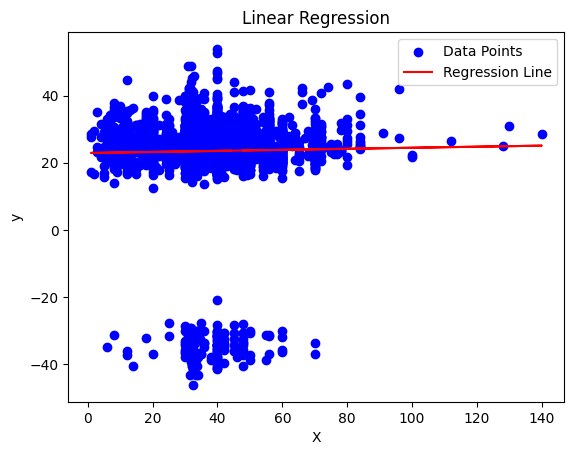

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for the data points
plt.scatter(X, y, color='blue', label='Data Points')

# Line plot for the linear regression predictions
y_pred_line = lr.predict(X)
plt.plot(X, y_pred_line, color='red', label='Regression Line')

plt.title('Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


In [ ]:
import statsmodels.formula.api as smf

# Sample formula for the sake of demonstration
formula = "BMI ~ WorkHours"
model = smf.ols(formula=formula, data=my_data).fit()


In [ ]:
# Calculate AIC
aic = model.aic
print("AIC:", aic)

# Calculate RSS
rss = sum(model.resid**2)
print("RSS:", rss)

AIC: 36576.91801804785
RSS: 684641.9375730897


**LR2**

In [ ]:
X = pd.DataFrame({
    'WorkHours': my_data['WorkHours'],
    'WorkHours_squared': my_data['WorkHours']**2
})
   # reshaping X to be a 2D array
y = my_data['BMI'].values

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


# Initialize the model
lr2 = LinearRegression()

#train the model on the train data
lr2.fit(X_train, y_train)
# Predict on the test set
y_pred = lr2.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, check the model's coefficients
print("Coefficients:", lr2.coef_)
print("Intercept:", lr2.intercept_)






Training set: (3271, 2) (3271,)
Test set: (1403, 2) (1403,)
Mean Squared Error: 151.789653081317
Coefficients: [-0.0888946   0.00123027]
Intercept: 24.88933766235266


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/valid

In [ ]:
import statsmodels.formula.api as smf
my_data['WorkHours_squared'] = my_data['WorkHours']**2

# Sample formula for the sake of demonstration
formula = "BMI ~ WorkHours + WorkHours_squared"
model = smf.ols(formula=formula, data=my_data).fit()
# Calculate AIC
aic = model.aic
print("AIC:", aic)

# Calculate RSS
rss = sum(model.resid**2)
print("RSS:", rss)

AIC: 36571.54102232945
RSS: 683562.2163396635


In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.847
Date:                Tue, 31 Oct 2023   Prob (F-statistic):             0.0214
Time:                        21:04:40   Log-Likelihood:                -18283.
No. Observations:                4674   AIC:                         3.657e+04
Df Residuals:                    4671   BIC:                         3.659e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            25.1254      0.92

**lr3**

In [ ]:
X = my_data[['WorkHours','SportsMember']]
  # reshaping X to be a 2D array
y = my_data['BMI'].values

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


# Initialize the model
lr2 = LinearRegression()

#train the model on the train data
lr2.fit(X_train, y_train)
# Predict on the test set
y_pred = lr2.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, check the model's coefficients
print("Coefficients:", lr2.coef_)
print("Intercept:", lr2.intercept_)





Training set: (3271, 2) (3271,)
Test set: (1403, 2) (1403,)
Mean Squared Error: 151.72886790800487
Coefficients: [0.01729257 0.58388355]
Intercept: 21.143802145057435


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/valid

In [ ]:
# Sample formula for the sake of demonstration
formula = "BMI ~ WorkHours+SportsMember"
model = smf.ols(formula=formula, data=my_data).fit()
# Calculate AIC
aic = model.aic
print("AIC:", aic)

# Calculate RSS
rss = sum(model.resid**2)
print("RSS:", rss)

AIC: 36573.77371109313
RSS: 683888.8201593062


In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.729
Date:                Tue, 31 Oct 2023   Prob (F-statistic):             0.0654
Time:                        21:04:41   Log-Likelihood:                -18284.
No. Observations:                4674   AIC:                         3.657e+04
Df Residuals:                    4671   BIC:                         3.659e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.7649      1.575     12.545   

**lr4**

Training set: (3271, 1) (3271,)
Test set: (1403, 1) (1403,)
Mean Squared Error: 151.64907283104085
Coefficients: [0.52480483]
Intercept: 21.974971238517217


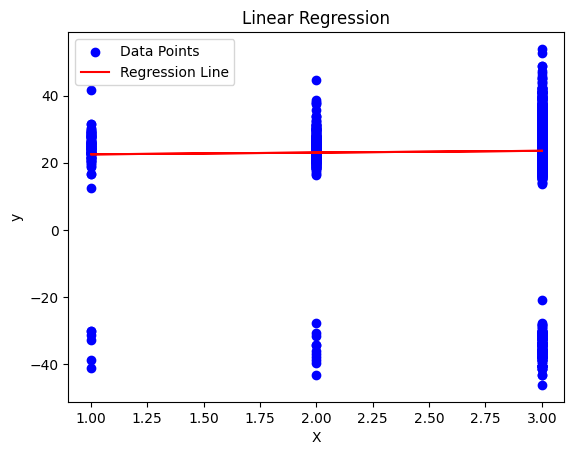

In [ ]:
X =  my_data['SportsMember']
X =X.values.reshape(-1, 1)   # reshaping X to be a 2D array
y = my_data['BMI'].values

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


# Initialize the model
lr2 = LinearRegression()

#train the model on the train data
lr2.fit(X_train, y_train)
# Predict on the test set
y_pred = lr2.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, check the model's coefficients
print("Coefficients:", lr2.coef_)
print("Intercept:", lr2.intercept_)


# Scatter plot for the data points
plt.scatter(X, y, color='blue', label='Data Points')

# Line plot for the linear regression predictions
y_pred_line = lr2.predict(X)
plt.plot(X, y_pred_line, color='red', label='Regression Line')

plt.title('Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()



In [ ]:
# Sample formula for the sake of demonstration
formula = "BMI ~ SportsMember"
model = smf.ols(formula=formula, data=my_data).fit()
# Calculate AIC
aic = model.aic
print("AIC:", aic)

# Calculate RSS
rss = sum(model.resid**2)
print("RSS:", rss)

AIC: 36572.32119954753
RSS: 683968.9320897469


In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.912
Date:                Tue, 31 Oct 2023   Prob (F-statistic):             0.0267
Time:                        21:04:42   Log-Likelihood:                -18284.
No. Observations:                4674   AIC:                         3.657e+04
Df Residuals:                    4672   BIC:                         3.659e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       20.2356      1.441     14.041   

**Linear regression model 5:**

In [ ]:
my_data.columns

Index(['Health', 'Weight', 'Female', 'Height', 'WorkStatus', 'WorkHours',
       'SportsMember', 'Divorce', 'age_pr', 'BMI', 'PreObese', 'Overtime',
       'WorkHours_squared'],
      dtype='object')

In [ ]:
X = my_data[['WorkStatus','Female', 'Divorce', 'WorkHours','SportsMember']]
  # reshaping X to be a 2D array
y = my_data['BMI'].values

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


# Initialize the model
lr5 = LinearRegression()

#train the model on the train data
lr5.fit(X_train, y_train)
# Predict on the test set
y_pred = lr5.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, check the model's coefficients
print("Coefficients:", lr5.coef_)
print("Intercept:", lr5.intercept_)


Training set: (3271, 5) (3271,)
Test set: (1403, 5) (1403,)
Mean Squared Error: 151.48315904996926
Coefficients: [ 0.         -1.1204451   0.14571245  0.01170341  0.61316209]
Intercept: 21.54455792126939


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/valid

In [ ]:
my_data.columns

Index(['Health', 'Weight', 'Female', 'Height', 'WorkStatus', 'WorkHours',
       'SportsMember', 'Divorce', 'age_pr', 'BMI', 'PreObese', 'Overtime',
       'WorkHours_squared'],
      dtype='object')

In [ ]:
# Sample formula for the sake of demonstration
formula = "BMI ~ WorkStatus+Female+Divorce+WorkHours+SportsMember"
model = smf.ols(formula=formula, data=my_data).fit()
# Calculate AIC
aic = model.aic
print("AIC:", aic)

# Calculate RSS
rss = sum(model.resid**2)
print("RSS:", rss)

AIC: 36568.78680681034
RSS: 682575.1405446866


In [ ]:

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.613
Date:                Tue, 31 Oct 2023   Prob (F-statistic):            0.00603
Time:                        21:04:42   Log-Likelihood:                -18279.
No. Observations:                4674   AIC:                         3.657e+04
Df Residuals:                    4669   BIC:                         3.660e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.0670      0.814     12.369   

Linear regression model 6:

In [ ]:
my_data.columns

Index(['Health', 'Weight', 'Female', 'Height', 'WorkStatus', 'WorkHours',
       'SportsMember', 'Divorce', 'age_pr', 'BMI', 'PreObese', 'Overtime',
       'WorkHours_squared'],
      dtype='object')

In [ ]:
import statsmodels.formula.api as smf

# Assuming `my_data` is a pandas DataFrame
train_data = my_data.sample(frac=0.7)  # Assuming train_data is 70% of my_data

model_formula = "BMI ~ WorkStatus + Overtime + Female + Divorce + WorkHours + SportsMember + age_pr + I(age_pr**2)"
lin_reg6 = smf.ols(formula=model_formula, data=train_data).fit()

print(lin_reg6.summary())


                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.599
Date:                Tue, 31 Oct 2023   Prob (F-statistic):           3.96e-05
Time:                        21:04:42   Log-Likelihood:                -12921.
No. Observations:                3272   AIC:                         2.586e+04
Df Residuals:                    3264   BIC:                         2.591e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.1259      1.352      6.

Linear regression model 7:

In [ ]:
import statsmodels.api as sm
# Defining the dependent and independent variables
X = my_data[['Female', 'WorkHours', 'SportsMember', 'age_pr']]
X['age_pr_squared'] = my_data['age_pr']**2
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = my_data['BMI']

# Fit the model
lin_reg7 = sm.GLM(y, X).fit()

# Print the summary
print(lin_reg7.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    BMI   No. Observations:                 4674
Model:                            GLM   Df Residuals:                     4668
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                          145.46
Method:                          IRLS   Log-Likelihood:                -18267.
Date:                Tue, 31 Oct 2023   Deviance:                   6.7901e+05
Time:                        21:04:42   Pearson chi2:                 6.79e+05
No. Iterations:                     3   Pseudo R-squ. (CS):           0.008322
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             14.8792      2.101      7.

/var/folders/yn/ksnvm4nd09sdpcxf18xmcvlc0000gn/T/ipykernel_1200/1043382322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['age_pr_squared'] = my_data['age_pr']**2


# 2- logistic:

**model 1:**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

X = my_data[['Female', 'WorkHours', 'SportsMember', 'age_pr']].copy()
X['age_pr_squared'] = X['age_pr'] ** 2
y = my_data['PreObese']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting logistic regression
model = LogisticRegression(max_iter=10000)  # Increased max_iter for convergence
model.fit(X_train, y_train)

# Get coefficients
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Predict on training data to get classification report and confusion matrix
y_pred_train = model.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Coefficients: [[-2.62863768e-01  1.27314679e-03 -3.09070532e-01  2.19433159e-02
   5.01659758e-05]]
Intercept: [-0.11138863]
[[1104  585]
 [ 766  816]]
              precision    recall  f1-score   support

         0.0       0.59      0.65      0.62      1689
         1.0       0.58      0.52      0.55      1582

    accuracy                           0.59      3271
   macro avg       0.59      0.58      0.58      3271
weighted avg       0.59      0.59      0.58      3271



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


**Model 2:**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Sample data loading (replace this with how you're loading your dataset)
# my_data = pd.read_csv('path_to_your_data.csv')

# Prepare your predictors and target variable
X = my_data[['Female', 'Overtime', 'Divorce', 'WorkHours', 'SportsMember', 'age_pr']]
X['age_pr_squared'] = X['age_pr'] ** 2
y = my_data['PreObese']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Fit the logistic regression model
model = LogisticRegression(max_iter=10000)  # Increased max_iter for better convergence
model.fit(X_train, y_train)

# Get coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

# To get classification report and confusion matrix on training data
y_pred_train = model.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

/var/folders/yn/ksnvm4nd09sdpcxf18xmcvlc0000gn/T/ipykernel_1200/2727088915.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['age_pr_squared'] = X['age_pr'] ** 2
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):


Coefficients: [[-0.1683479  -0.05117097 -0.04854029  0.00679735 -0.14137219  0.07494844
  -0.00048293]]
Intercept: [-1.94171713]
[[1022  667]
 [ 680  902]]
              precision    recall  f1-score   support

         0.0       0.60      0.61      0.60      1689
         1.0       0.57      0.57      0.57      1582

    accuracy                           0.59      3271
   macro avg       0.59      0.59      0.59      3271
weighted avg       0.59      0.59      0.59      3271



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


**Model 3:**

In [ ]:
X = my_data[['Female', 'Divorce', 'age_pr']]
X['age_pr_squared'] = X['age_pr'] ** 2
y = my_data['PreObese']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Fit the logistic regression model
model = LogisticRegression(max_iter=10000)  # Increased max_iter for better convergence
model.fit(X_train, y_train)

# Get coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

# To get classification report and confusion matrix on training data
y_pred_train = model.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


/var/folders/yn/ksnvm4nd09sdpcxf18xmcvlc0000gn/T/ipykernel_1200/1878927911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['age_pr_squared'] = X['age_pr'] ** 2
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/

Coefficients: [[-0.22677334  0.03645576  0.07194304 -0.00047389]]
Intercept: [-2.1539392]
[[1018  671]
 [ 666  916]]
              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60      1689
         1.0       0.58      0.58      0.58      1582

    accuracy                           0.59      3271
   macro avg       0.59      0.59      0.59      3271
weighted avg       0.59      0.59      0.59      3271



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


#  3- Probit Model

**probit 1:**

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

train_data['age_pr_squared'] = train_data['age_pr'] ** 2



# Fit the probit regression model
formula = "PreObese ~ Female + Divorce + age_pr + age_pr_squared"
probit_model = smf.probit(formula, data=train_data).fit()

# Print the summary
print(probit_model.summary())


Optimization terminated successfully.
         Current function value: 0.666285
         Iterations 4
                          Probit Regression Results                           
Dep. Variable:               PreObese   No. Observations:                 3272
Model:                         Probit   Df Residuals:                     3267
Method:                           MLE   Df Model:                            4
Date:                Tue, 31 Oct 2023   Pseudo R-squ.:                 0.03785
Time:                        21:45:22   Log-Likelihood:                -2180.1
converged:                       True   LL-Null:                       -2265.8
Covariance Type:            nonrobust   LLR p-value:                 4.919e-36
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.3884      0.196     -7.081      0.000      -1.773      -1.004
Female           

# 4- Classification

**DecisionTreeClassifier:**

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


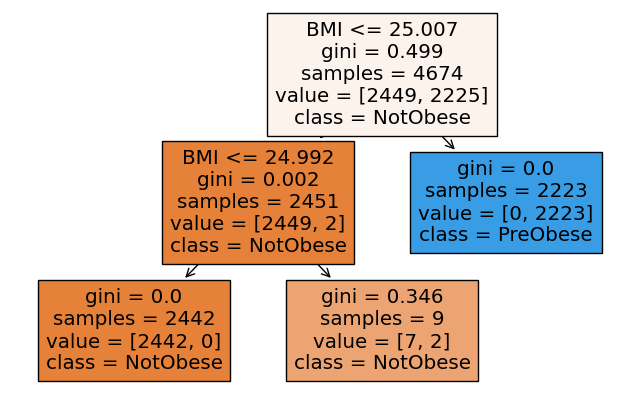

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# Sample data loading (replace this with how you're loading your dataset)
# my_data = pd.read_csv('path_to_your_data.csv')

# Preparing the features and target
X = my_data[['BMI']]  # Assuming BMI is a single column in your data
y = my_data['PreObese']

# Fit the decision tree classifier
clf = DecisionTreeClassifier(max_depth=None)  # Adjust max_depth if needed
clf = clf.fit(X, y)

# Plotting the tree
fig, ax = plt.subplots(figsize=(8, 5))
tree.plot_tree(clf, filled=True, feature_names=['BMI'], class_names=["NotObese", "PreObese"])
plt.savefig('Obesity tree.jpg')
plt.show()


**SVM**

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Number of support vectors for each class: [40 40]


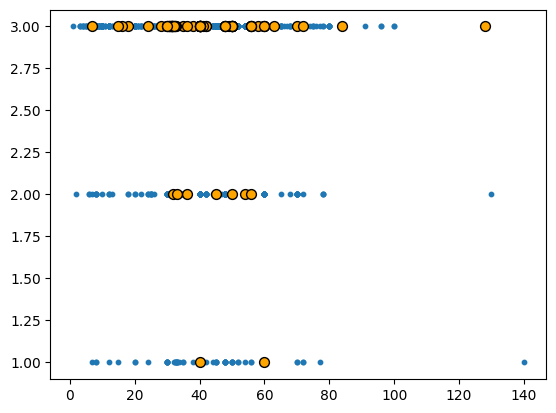

In [ ]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt

X = train_data.drop('PreObese', axis=1)
y = train_data['PreObese']

# Create and train the SVM classifier with a linear kernel
clf = SVC(kernel='linear', C=1, max_iter=-1)  # max_iter=-1 for no limit on iterations
clf.fit(X, y)

# Number of support vectors for each class
print("Number of support vectors for each class:", clf.n_support_)

# Plotting support vectors (assuming the dataframe has columns named '5' and '6')
plt.scatter(train_data.iloc[:, 5], train_data.iloc[:, 6], s=10)
plt.scatter(clf.support_vectors_[:, 5], clf.support_vectors_[:, 6], color='orange', s=50, edgecolors='k')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming clf is the trained SVM classifier and test_data is your testing dataset

# Getting predictions
svm_pred = clf.predict(test_data.drop('PreObese', axis=1))

# True labels
svm_test = test_data['PreObese']

# Creating a confusion matrix
svm_matrix = confusion_matrix(svm_test, svm_pred, labels=[1, 0])
print(svm_matrix)

# Calculating accuracy
svm_accuracy = accuracy_score(svm_test, svm_pred)
print(svm_accuracy)


[[426   5]
 [  6 498]]
0.9882352941176471


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


# 4. INTERPRETATIONS

In [ ]:
import statsmodels.api as sm


X = my_data[['Female', 'WorkHours', 'SportsMember', 'age_pr']].copy()
X['age_pr^2'] = my_data['age_pr']**2

# Add a constant (intercept) to the predictors matrix
X = sm.add_constant(X)

# The dependent variable
y = my_data['BMI']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.811
Date:                Tue, 31 Oct 2023   Prob (F-statistic):           2.48e-07
Time:                        22:18:11   Log-Likelihood:                -18267.
No. Observations:                4674   AIC:                         3.655e+04
Df Residuals:                    4668   BIC:                         3.658e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           14.8792      2.101      7.082   